# Exploratory Data Analysis on Fake and Real News Articles

This notebook connects to a validated SQLite database and performs exploratory data analysis (EDA) on fake and real news articles. The goal is to understand data distributions, subject coverage, publication trends, and content characteristics prior to preprocessing and modeling.

This notebook is the **second** in a series of four that together form a complete fake news detection pipeline. It performs exploratory data analysis (EDA) on the cleaned data stored in the SQLite database.

# Setup and Imports

In [1]:
# Import required libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sqlalchemy import create_engine  # Add this import
from tqdm import tqdm  # for progress bar

# Set plot aesthetics
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Mount Google Drive for file access
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Define file paths
db_path = '/content/drive/MyDrive/IS619_Project/fakenews.db'
fake_path = '/content/drive/MyDrive/IS619_Project/Fake.csv'
true_path = '/content/drive/MyDrive/IS619_Project/True.csv'

# SQLAlchemy engine to interface with SQLite
engine = create_engine(f'sqlite:///{db_path}')  # <-- Add this line

Mounted at /content/drive


# Database Overview

In [2]:
# Connect to the SQLite database
conn = sqlite3.connect(db_path)
cur = conn.cursor()

# Show all tables present in the database
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print("Tables in database:", [t[0] for t in cur.fetchall()])

# Check row count in the main news_article table
cur.execute("SELECT COUNT(*) FROM news_article;")
print(f"'news_article' table has {cur.fetchone()[0]} rows.")

# Close connection
conn.close()

Tables in database: ['news_article_with_id', 'analysis_article', 'news_article', 'article_word_fact', 'bag_of_word_dim', 'topic_dim', 'article_topic', 'time_dim', 'entity_dim']
'news_article' table has 179552 rows.


# Raw CSV Data Inspection

In [3]:
# Load original raw CSVs
fake_df = pd.read_csv(fake_path)
true_df = pd.read_csv(true_path)

# Display row counts
print(f"Fake.csv rows: {len(fake_df)}")
print(f"True.csv rows: {len(true_df)}")

# Display count of null values per column
print("\nFake nulls:\n", fake_df.isnull().sum())
print("True nulls:\n", true_df.isnull().sum())

# Show how subjects are distributed in raw files
print("\nFake subject distribution:\n", fake_df['subject'].value_counts())
print("True subject distribution:\n", true_df['subject'].value_counts())

Fake.csv rows: 23481
True.csv rows: 21417

Fake nulls:
 title      0
text       0
subject    0
date       0
dtype: int64
True nulls:
 title      0
text       0
subject    0
date       0
dtype: int64

Fake subject distribution:
 subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64
True subject distribution:
 subject
politicsNews    11272
worldnews       10145
Name: count, dtype: int64


# Cleaned Data Inspection (news_article Table)

In [4]:
# Load cleaned data from the database
conn = sqlite3.connect(db_path)
df_db = pd.read_sql_query("SELECT * FROM news_article", conn)
conn.close()

# Preview the first few rows
print(df_db.head())

# Null value summary
print("\nNull values:\n", df_db.isnull().sum())

# Subject distribution
print("\nSubject distribution:\n", df_db['subject'].value_counts())

# Fake vs real label distribution
print("\nFakeNews label distribution:\n", df_db['fakeNews'].value_counts())

# Earliest and latest article dates
print("Date range:", df_db['date'].min(), "to", df_db['date'].max())

                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                body   subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  POLITICS   
1  WASHINGTON (Reuters) - Transgender people will...  POLITICS   
2  WASHINGTON (Reuters) - The special counsel inv...  POLITICS   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  POLITICS   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  POLITICS   

                 date fakeNews article_id  
0  December 31, 2017      REAL          1  
1  December 29, 2017      REAL          2  
2  December 31, 2017      REAL          3  
3  December 30, 2017      REAL          4  
4  December 29, 2017      REAL          5  

N

# Distribution of Articles Across Subjects

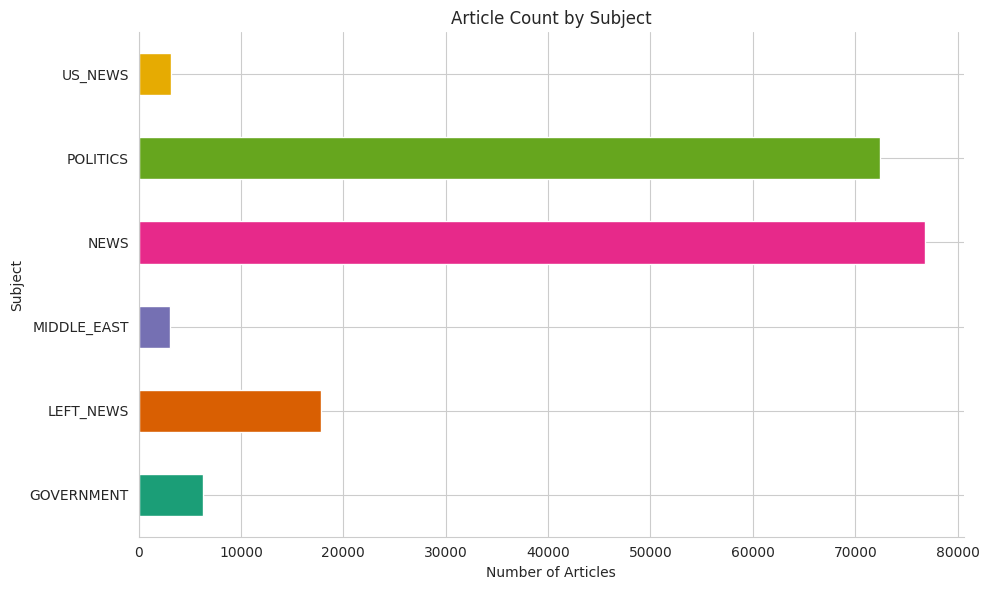

In [ ]:
# Group the data by 'subject' and count the number of articles per subject,
# then plot as a horizontal bar chart with a colorful palette
df_db.groupby('subject').size().plot(
    kind='barh',  # Horizontal bar chart
    color=sns.palettes.mpl_palette('Dark2')  # Use distinct colors for each bar
)

# Remove the top and right borders from the plot for a cleaner appearance
plt.gca().spines[['top', 'right']].set_visible(False)

# Add chart title and axis labels
plt.title('Article Count by Subject')
plt.xlabel('Number of Articles')
plt.ylabel('Subject')

# Adjust layout to prevent label overlap
plt.tight_layout()

# Display the plot
plt.show()


# Time Dimension Extraction & Load

In [ ]:
# This section extracts various time attributes from the 'date' column
# in the news_article table and creates a corresponding time_dim dimension table.

# Ensure 'date' is datetime type
df_db['date'] = pd.to_datetime(df_db['date'], errors='coerce')

# Drop nulls in date (if any)
df_time = df_db.dropna(subset=['date']).copy()

# Extract time-based features
df_time['time_id'] = df_time['date'].dt.strftime('%Y%m%d').astype(int)
df_time['year'] = df_time['date'].dt.year
df_time['month'] = df_time['date'].dt.month
df_time['day'] = df_time['date'].dt.day
df_time['quarter'] = df_time['date'].dt.quarter
df_time['week'] = df_time['date'].dt.isocalendar().week
df_time['day_of_week'] = df_time['date'].dt.dayofweek
df_time['day_of_year'] = df_time['date'].dt.dayofyear
df_time['is_weekend'] = df_time['day_of_week'].isin([5, 6]).astype(int)

# Drop duplicates to get unique time entries
time_dim_df = df_time[[
    'time_id', 'date', 'year', 'quarter', 'month', 'day',
    'week', 'day_of_week', 'day_of_year', 'is_weekend'
]].drop_duplicates(subset=['time_id'])

# Save to SQLite as time_dim table
time_dim_df.to_sql(
    name='time_dim',
    con=engine,
    index=False,
    if_exists='replace',  # You may want 'append' instead, if needed
    method='multi'
)

# Optional: Display a preview
print("Time Dimension Preview:")
display(time_dim_df.head())

Time Dimension Preview:


,time_id,date,year,quarter,month,day,week,day_of_week,day_of_year,is_weekend
0,20171231,2017-12-31,2017,4,12,31,52,6,365,1
1,20171229,2017-12-29,2017,4,12,29,52,4,363,0
3,20171230,2017-12-30,2017,4,12,30,52,5,364,1
9,20171228,2017-12-28,2017,4,12,28,52,3,362,0
14,20171225,2017-12-25,2017,4,12,25,52,0,359,0


from matplotlib import pyplot as plt
_df_0['time_id'].plot(kind='hist', bins=20, title='time_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['day'].plot(kind='hist', bins=20, title='day')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['day_of_week'].plot(kind='hist', bins=20, title='day_of_week')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['day_of_year'].plot(kind='hist', bins=20, title='day_of_year')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='time_id', y='day', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='day', y='day_of_week', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='day_of_week', y='day_of_year', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='day_of_year', y='is_weekend', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['day']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('day')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['day_of_week']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('day_of_week')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['day_of_year']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('day_of_year')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['is_weekend']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('is_weekend')

from matplotlib import pyplot as plt
_df_12['time_id'].plot(kind='line', figsize=(8, 4), title='time_id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['day'].plot(kind='line', figsize=(8, 4), title='day')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['day_of_week'].plot(kind='line', figsize=(8, 4), title='day_of_week')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['day_of_year'].plot(kind='line', figsize=(8, 4), title='day_of_year')
plt.gca().spines[['top', 'right']].set_visible(False)

# Article-Level Analysis: Word Count, Sentiment, Readability

In [ ]:
# Reconnect to database
conn = sqlite3.connect(db_path)

# Create the analysis_article table (if not already created)
conn.execute('''
CREATE TABLE IF NOT EXISTS analysis_article (
    article_id INTEGER NOT NULL,
    word_count INTEGER,
    sentiment_score REAL,
    polarity REAL,
    readability_score REAL,
    FOREIGN KEY (article_id) REFERENCES news_article(article_id)
);
''')

# Load analysis_article table into DataFrame for exploration
df_analysis = pd.read_sql_query("SELECT * FROM analysis_article;", conn)
conn.close()

# Display basic stats
print(f"Total rows in analysis_article: {len(df_analysis)}")
print("\nMissing values per column:")
print(df_analysis.isnull().sum())

# Optional: Preview sample rows
df_analysis.head()

Total rows in analysis_article: 134664

Missing values per column:
article_id           0
word_count           0
sentiment_score      0
polarity             0
readability_score    0
dtype: int64


,article_id,word_count,sentiment_score,polarity,readability_score
0,1,749,0.410250,0.037083,45.557134
1,2,624,0.298557,0.055880,34.876171
2,3,457,0.316798,0.115930,46.392368
3,4,376,0.306569,0.035968,39.259705
4,5,852,0.399891,0.030093,49.925693


from matplotlib import pyplot as plt
_df_16['article_id'].plot(kind='hist', bins=20, title='article_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_17['word_count'].plot(kind='hist', bins=20, title='word_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_18['sentiment_score'].plot(kind='hist', bins=20, title='sentiment_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_19['polarity'].plot(kind='hist', bins=20, title='polarity')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_20.plot(kind='scatter', x='article_id', y='word_count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_21.plot(kind='scatter', x='word_count', y='sentiment_score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_22.plot(kind='scatter', x='sentiment_score', y='polarity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_23.plot(kind='scatter', x='polarity', y='readability_score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['article_id']
  ys = series['word_count']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_24.sort_values('article_id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('article_id')
_ = plt.ylabel('word_count')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['article_id']
  ys = series['sentiment_score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_25.sort_values('article_id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('article_id')
_ = plt.ylabel('sentiment_score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['article_id']
  ys = series['polarity']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_26.sort_values('article_id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('article_id')
_ = plt.ylabel('polarity')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['article_id']
  ys = series['readability_score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_27.sort_values('article_id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('article_id')
_ = plt.ylabel('readability_score')

from matplotlib import pyplot as plt
_df_28['article_id'].plot(kind='line', figsize=(8, 4), title='article_id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_29['word_count'].plot(kind='line', figsize=(8, 4), title='word_count')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_30['sentiment_score'].plot(kind='line', figsize=(8, 4), title='sentiment_score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_31['polarity'].plot(kind='line', figsize=(8, 4), title='polarity')
plt.gca().spines[['top', 'right']].set_visible(False)

# Named Entity Extraction & Entity Dimension Table Creation
####Note that this will take *quite some time* (~2hr) to run.

In [ ]:
# Load spaCy English model with unused pipeline components disabled
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "lemmatizer"])

# Create engine and load articles
engine = create_engine(f'sqlite:///{db_path}')
df_articles = pd.read_sql("SELECT article_id, body FROM news_article", engine)

# Pre-filter to remove empty or extremely short texts
df_articles = df_articles[df_articles['body'].str.len() > 20]

# Convert to list of tuples for spaCy processing
text_id_pairs = list(zip(df_articles['body'], df_articles['article_id']))

# Process texts in parallel and collect entities
entity_records = []
for doc, article_id in tqdm(
    nlp.pipe(text_id_pairs, as_tuples=True, batch_size=25, n_process=2), #The max batch_size and n_process when running this in Google Colab can only be maxed out at "25" for batch and "2" for process (CPU core count)
    total=len(text_id_pairs)
):
    for ent in doc.ents:
        entity_records.append({
            'article_id': article_id,
            'entity_text': ent.text,
            'entity_label': ent.label_
        })

# Convert to DataFrame, drop duplicates, and save to DB
entity_df = pd.DataFrame(entity_records).drop_duplicates()
entity_df.to_sql('entity_dim', con=engine, index=False, if_exists='replace')

# Display sample
print("Sample extracted entities:")
display(entity_df.head())

#This code-block runs in about 2hrs 43min  | 7/30/2025

100%|██████████| 176860/176860 [2:43:06<00:00, 18.07it/s]


Sample extracted entities:


,article_id,entity_text,entity_label
0,1,WASHINGTON,GPE
1,1,Reuters,ORG
2,1,Republican,NORP
3,1,the U.S. Congress,ORG
4,1,this month,DATE


# Merge Articles with Topics, Article, and Time Metadata



In [ ]:
# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# Load required tables
article_topic_df = pd.read_sql("SELECT * FROM article_topic", conn)
topics_df = pd.read_sql("SELECT * FROM topic_dim", conn)
articles_df = pd.read_sql("SELECT * FROM news_article", conn)
time_df = pd.read_sql("SELECT * FROM time_dim", conn)

# Close connection
conn.close()

# Merge article_topic to get topic labels
articles_topics = pd.merge(article_topic_df, topics_df, on='topic_id', how='left')

# Merge articles with topic info
articles_full = pd.merge(articles_df, articles_topics, on='article_id', how='left')

# Merge with time_dim using 'date' as the key instead of 'article_id'
articles_full = pd.merge(articles_full, time_df, on='date', how='left')

# Topic Distribution Visualization

/tmp/ipython-input-9-3203478088.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=topic_counts.index, x=topic_counts.values, palette='viridis')


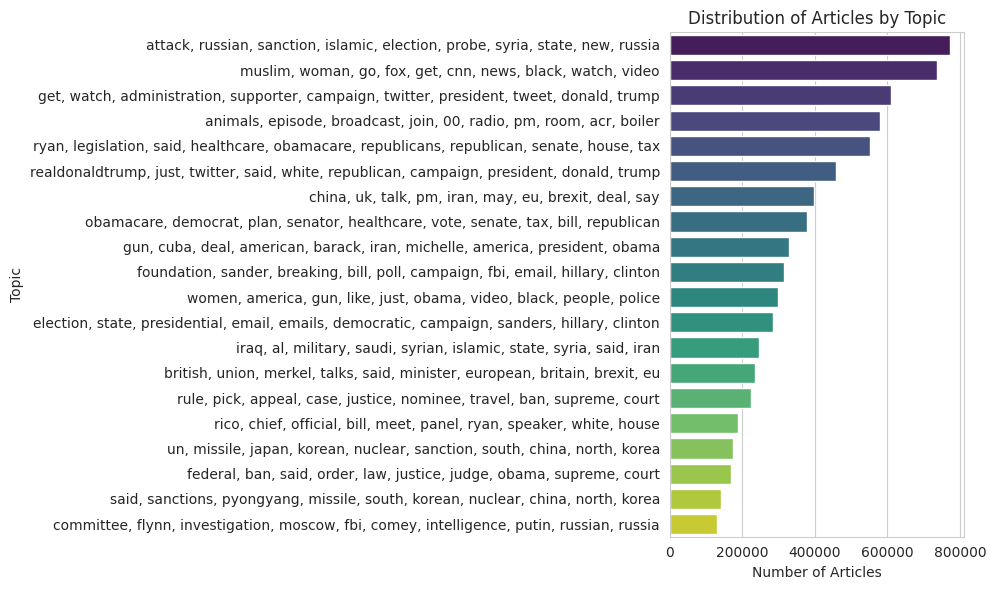

In [ ]:
# Count number of articles per topic
topic_counts = articles_full['topic_name'].value_counts().sort_values(ascending=False)

# Plot the distribution of topics
plt.figure(figsize=(10, 6))
sns.barplot(y=topic_counts.index, x=topic_counts.values, palette='viridis')
plt.xlabel('Number of Articles')
plt.ylabel('Topic')
plt.title('Distribution of Articles by Topic')
plt.tight_layout()
plt.show()

# Article Volume Over Time by Subject

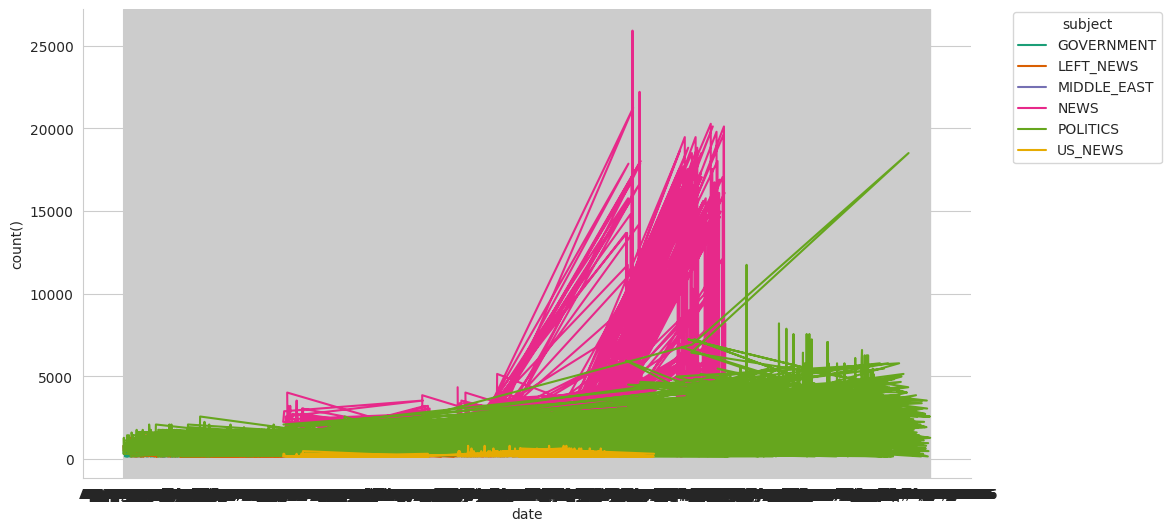

In [ ]:
# Define a helper function to plot a time series for each subject group
def _plot_series(series, series_name, series_index=0):
    # Use a predefined color palette for consistency
    palette = list(sns.palettes.mpl_palette('Dark2'))

    # Count how many articles appear on each date
    counted = (series['date']
                  .value_counts()
                  .reset_index(name='counts')  # Create a 'counts' column
                  .rename({'index': 'date'}, axis=1)  # Rename the date column
                  .sort_values('date', ascending=True))  # Sort by date for time series

    # Extract x and y values for plotting
    xs = counted['date']
    ys = counted['counts']

    # Plot the series with a label and a color from the palette
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

# Create a figure and axis with constrained layout to prevent label overlap
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')

# Sort the full dataset by date to ensure chronological plotting
df_sorted = articles_full.sort_values('date', ascending=True)

# Group by 'subject' and plot a time series for each group
for i, (series_name, series) in enumerate(df_sorted.groupby('subject')):
    _plot_series(series, series_name, i)  # Plot each subject's time series

# Add a legend showing subject names
fig.legend(title='subject', bbox_to_anchor=(1, 1), loc='upper left')

# Remove top and right plot spines for a cleaner appearance
sns.despine(fig=fig, ax=ax)

# Label the axes
plt.xlabel('date')
_ = plt.ylabel('count()')  # Use underscore to suppress output in notebook

# Article-Level Feature Summary

In [ ]:
# Join article-level features with label and metadata
conn = sqlite3.connect(db_path)
df_combined = pd.read_sql_query(
    '''
    SELECT a.*, n.subject, n."fakeNews", n.date
    FROM analysis_article a
    JOIN news_article n ON a.article_id = n.article_id
    ''',
    conn
)
conn.close()

# Summary statistics
print(df_combined.describe())

# Grouped average values by Fake vs Real
print("\nGrouped by fakeNews:\n", df_combined.groupby('fakeNews').mean(numeric_only=True))

          article_id     word_count  sentiment_score       polarity  \
count  134664.000000  134664.000000    134664.000000  134664.000000   
mean    22444.500000     405.371191         0.399419       0.056643   
std     12958.097551     351.251520         0.132781       0.106530   
min         1.000000       0.000000         0.000000      -1.000000   
25%     11222.750000     203.000000         0.336667       0.000000   
50%     22444.500000     362.000000         0.406244       0.053767   
75%     33666.250000     513.000000         0.474993       0.108230   
max     44888.000000    8135.000000         1.000000       1.000000   

       readability_score  
count      134664.000000  
mean           45.536041  
std            18.586733  
min          -809.380000  
25%            38.883496  
50%            46.338619  
75%            54.069509  
max           121.220000  

Grouped by fakeNews:
           article_id  word_count  sentiment_score  polarity  readability_score
fakeNews       

# Boxplots of Key Metrics

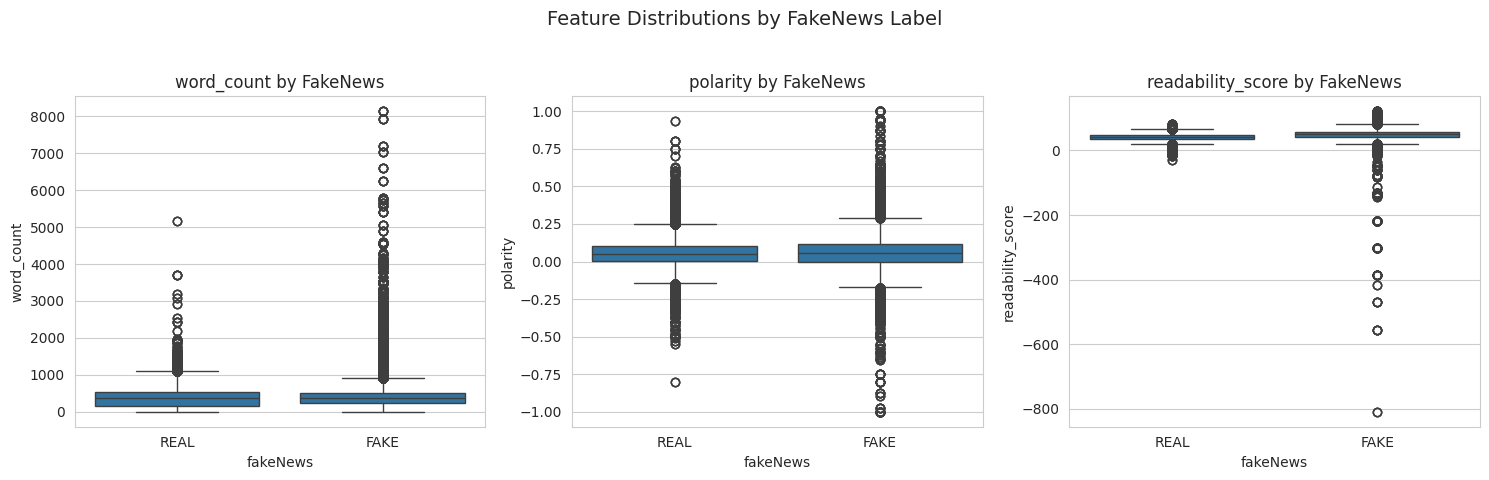

In [ ]:
# Visualize distributions of key features by FakeNews label
metrics = ['word_count', 'polarity', 'readability_score']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.suptitle('Feature Distributions by FakeNews Label', fontsize=14)

# Draw boxplot for each feature
for idx, metric in enumerate(metrics):
    sns.boxplot(data=df_combined, x='fakeNews', y=metric, ax=axes[idx])
    axes[idx].set_title(f"{metric} by FakeNews")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Bag-of-Words Summary

   word_id word_text stemmed_text  is_stop_word  tfidf_score  frequency  \
0        1       000          000             0     0.012037       6426   
1        2        10           10             0     0.007502       4705   
2        3       100          100             0     0.004599       2729   
3        4        11           11             0     0.005540       2908   
4        5        12           12             0     0.005004       2766   

  part_of_speech  term_topic_cluster  
0            NUM                   6  
1            NUM                   6  
2            NUM                   6  
3            NUM                   6  
4            NUM                   6  
count    1000.000000
mean        0.006415
std         0.005127
min         0.002787
25%         0.003911
50%         0.004960
75%         0.007048
max         0.089360
Name: tfidf_score, dtype: float64
count     1000.000000
mean      3249.358000
std       2714.380872
min        368.000000
25%       1813.750000
50%

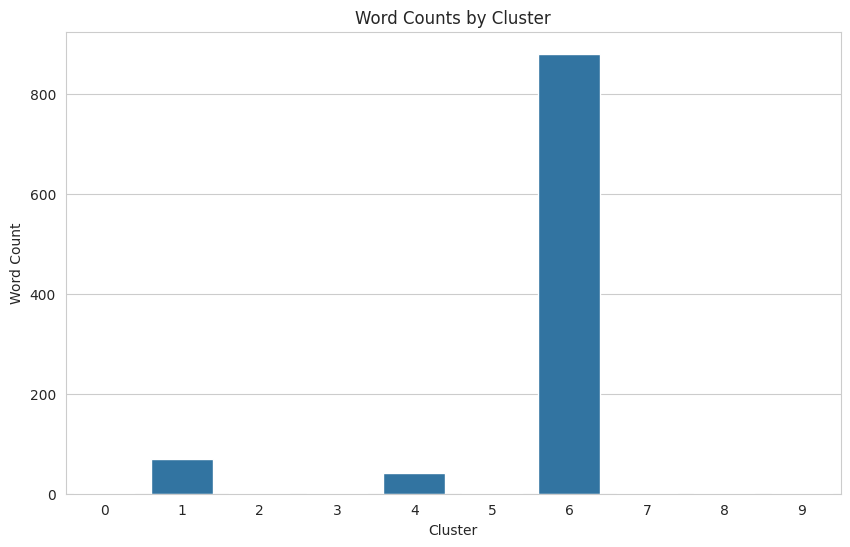

In [ ]:
# Load BoW data from database
conn = sqlite3.connect(db_path)
df_bow = pd.read_sql_query("SELECT * FROM bag_of_word_dim", conn)
conn.close()

# Show structure of BoW table
print(df_bow.head())

# Descriptive statistics
print(df_bow['tfidf_score'].describe())
print(df_bow['frequency'].describe())

# Part of speech and stop word distributions
print("\nPart of speech distribution:\n", df_bow['part_of_speech'].value_counts())
print("\nStop word count:", df_bow['is_stop_word'].sum())

# Topic cluster breakdown
print("\nCluster breakdown:\n", df_bow['term_topic_cluster'].value_counts())

# Visualize word counts by cluster
sns.countplot(x='term_topic_cluster', data=df_bow)
plt.title("Word Counts by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Word Count")
plt.show()

# Time Dimension Analysis

Date range: 2016-01-13 00:00:00 to 2017-12-31 00:00:00

Month distribution:
 month
1     50
2     57
3     62
4     60
5     61
6     60
7     62
8     61
9     60
10    62
11    60
12    61
Name: count, dtype: int64

Quarter distribution:
 quarter
1    169
2    181
3    183
4    183
Name: count, dtype: int64

Weekday breakdown:
 day_of_week
6    103
4    103
3    103
2    103
0    102
1    102
5    100
Name: count, dtype: int64

Weekend vs. Weekday:
 is_weekend
0    513
1    203
Name: count, dtype: int64

Yearly count:
 year
2016    352
2017    364
Name: count, dtype: int64

Articles per month:
 month_year
2016-01    19
2016-02    29
2016-03    31
2016-04    30
2016-05    31
2016-06    30
2016-07    31
2016-08    30
2016-09    30
2016-10    31
2016-11    30
2016-12    30
2017-01    31
2017-02    28
2017-03    31
2017-04    30
2017-05    30
2017-06    30
2017-07    31
2017-08    31
2017-09    30
2017-10    31
2017-11    30
2017-12    31
Freq: M, dtype: int64


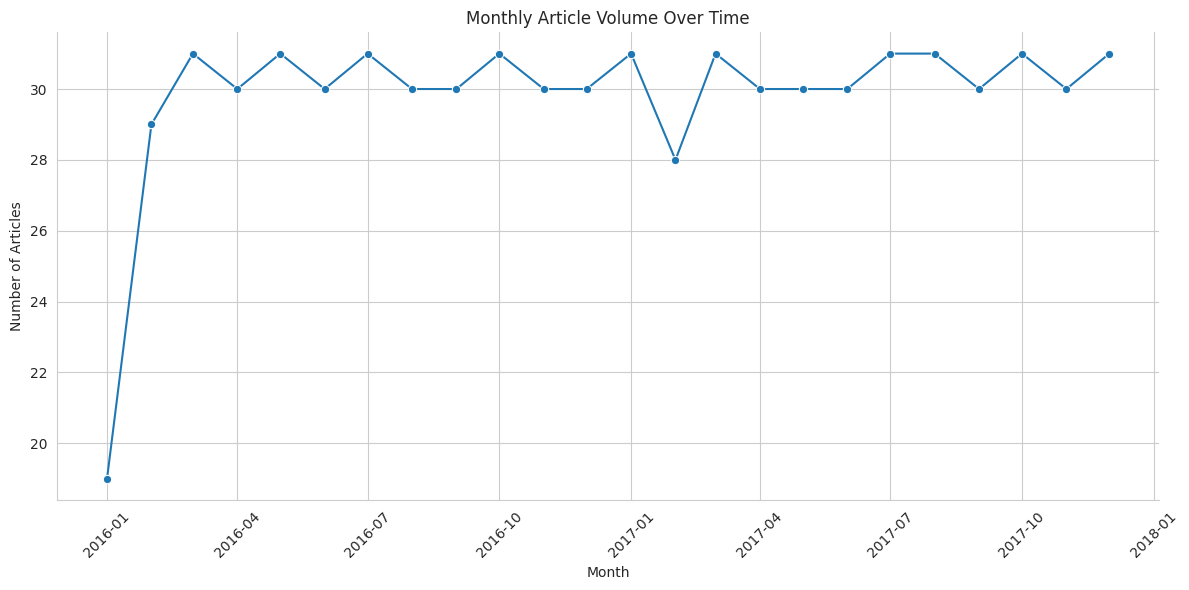

In [ ]:
# Load time dimension table
conn = sqlite3.connect(db_path)
time_dim = pd.read_sql_query("SELECT * FROM time_dim", conn)
conn.close()

# Convert to datetime
time_dim['date'] = pd.to_datetime(time_dim['date'])

# Overview stats
print("Date range:", time_dim['date'].min(), "to", time_dim['date'].max())
print("\nMonth distribution:\n", time_dim['month'].value_counts().sort_index())
print("\nQuarter distribution:\n", time_dim['quarter'].value_counts().sort_index())
print("\nWeekday breakdown:\n", time_dim['day_of_week'].value_counts())  # ← fixed
print("\nWeekend vs. Weekday:\n", time_dim['is_weekend'].value_counts())
print("\nYearly count:\n", time_dim['year'].value_counts().sort_index())

# Monthly distribution over time
time_dim['month_year'] = time_dim['date'].dt.to_period('M')
monthly_distribution = time_dim.groupby('month_year').size()

# Print monthly trend
print("\nArticles per month:\n", monthly_distribution)

# Convert PeriodIndex to datetime for plotting
monthly_distribution.index = monthly_distribution.index.to_timestamp()

# Create line plot of monthly article count
plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_distribution.index, y=monthly_distribution.values, marker='o')

# Style the chart
plt.title('Monthly Article Volume Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
sns.despine()
plt.tight_layout()

# Show the plot
plt.show()